# Análise de diferença salarial dentro do setor de TI (2009)
#### Para trabalhadores de CBOs de TI

## Imports e leitura dos dados:

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from statsmodels.graphics.gofplots import qqplot
from scipy.stats import shapiro
from scipy.stats import normaltest
from scipy.stats import mannwhitneyu

# Opções gerais necessárias:

pd.options.display.float_format = "{:,.2f}".format

In [8]:
# Leitura da tabela principal:
RAIS_2009 = pd.read_csv("../data/raw/DATA_RAIS_setorTI_2009.csv", sep = ";", encoding = 'utf-8', skipinitialspace = True)

# Renomeando as colunas:
RAIS_2009.rename(columns = {'CBO Ocupação 2002':'CBO', 'CNAE 2.0 Classe':'CNAE',
                            'Escolaridade após 2005':'Escolaridade',
                            'Raça Cor':'Raça', 'Vl Remun Dezembro Nom':'Remuneração',
                            'Sexo Trabalhador':'Sexo'}, inplace = True)

# Criando indices dos sexos para utilização posterior:
sexo = {1: 'M', 2: 'F'}

# Filtrando os dados só para aqueles que tem sexo masculino e outra variável para feminino:
RAIS_2009_masculino = RAIS_2009.query("Sexo == 1")
RAIS_2009_feminino = RAIS_2009.query("Sexo == 2")

# Variável com o nível de confiança a ser considerado e utilizado:
nivel_confianca = 0.01

# Exibindo os cinco primeiros dados da tabela:
RAIS_2009.head()

,UF,CBO,CNAE,Escolaridade,Idade,Raça,Remuneração,Sexo
0,AC,212405,63119,6,53,09,"6,361.98",1
1,AC,317205,63119,6,50,09,"4,535.76",1
2,AC,317205,63119,6,50,09,"3,332.64",1
3,AC,212420,63119,6,19,09,544.00,1
4,AC,212405,63119,7,54,09,"6,391.52",1


## Visualização e análise da distribuição da variável remuneração:

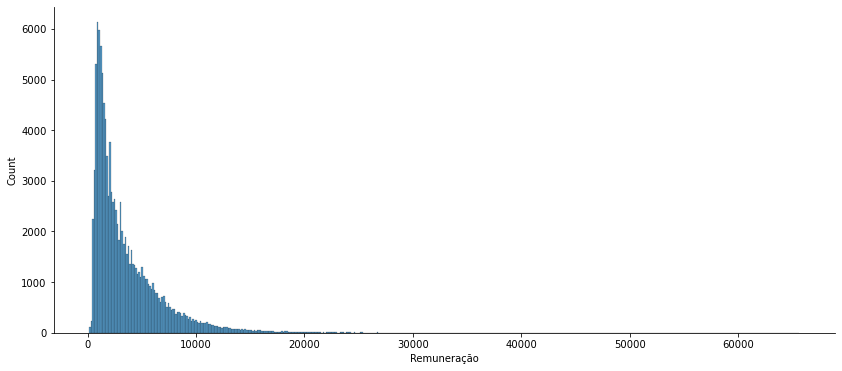

In [9]:
fig, ax = plt.subplots()
fig.set_size_inches(14, 6)

sns.histplot(RAIS_2009.Remuneração)
sns.despine()

fig.savefig("./figures/svg/hist_remuneracao_setorTI_2009.svg")
fig.savefig("./figures/png/hist_remuneracao_setorTI_2009.png")

Como podemos ver no gráfico acima, a disbribuição da variável principal provavelmente não segue uma normal, visto seu forte achatamento ao lado esquerdo.
  
Isto ocorre pelo comportamento das remunerações no país. Temos a maioria da população recebendo salários mais próximos de 0 do que de 60 mil, visto o cenário ruim de distribuição de renda.

Abaixo é exemplicado nos dados utilizados no trabalho esta desproporção de renda.

In [6]:
print("Soma dos salários dos trabalhadores 1% mais ricos: {}".format(RAIS_2009.Remuneração[RAIS_2009.Remuneração > RAIS_2009.Remuneração.quantile(0.99)].sum()))
print("Quantidade de trabalhadores 1% mais ricos: {}".format(RAIS_2009.Remuneração[RAIS_2009.Remuneração > RAIS_2009.Remuneração.quantile(0.99)].count()))

print()

print("Soma dos salários dos trabalhadores 24% mais pobres, aproximadamente: {}".format(RAIS_2009.Remuneração[RAIS_2009.Remuneração < RAIS_2009.Remuneração.quantile(0.237)].sum()))
print("Quantidade de trabalhadores 24% mais pobres: {}".format(RAIS_2009.Remuneração[RAIS_2009.Remuneração < RAIS_2009.Remuneração.quantile(0.237)].count()))

Soma dos salários dos trabalhadores 1% mais ricos: 25029485.23
Quantidade de trabalhadores 1% mais ricos: 1165

Soma dos salários dos trabalhadores 24% mais pobres, aproximadamente: 25019673.43
Quantidade de trabalhadores 24% mais pobres: 27509


Logo, o salário somado de todas as 1.165 pessoas mais ricas em funções trabalhistas de TI e em setores da TI é aproximadamente de 25 milhões de reais. Enquanto são necessárias 27.509 pessoas de menor renda para, no total, termos o equivalmente salarial dos 1% mais ricos, demonstrando que a desigualdade de renda é observanda, não somente no país ao todo, mas também nas ocupações de TI que trabalham nos setores de TI.

Para garantir que a distribuição não é normal, é necessário realizar alguns testes de normalidade. Isto é importante para mais a frente ser possível comparar as médias (dos salários entre sexos) corretamente. Caso seja uma normal, são utilizados testes específicos para a comparação, caso não seja normal, deve-se utilizar a abordagem não paramétrica.

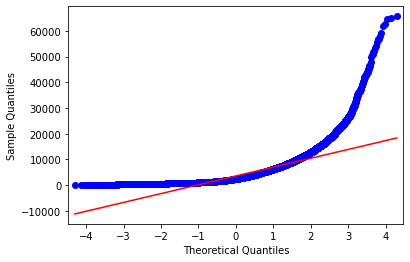

In [10]:
qqplot(RAIS_2009.Remuneração, line='s')
plt.show()

No gráfico acima, podemos sugerir visualmente que a distribuição não é normal, visto que as bordas da linha azul passam bem longe da linha vermelha. Para uma possível conclusão de normalidade, está linha deve estar o mais próximo possível da linha vermelha.

É necessário realizar um teste de normalidade para concluir estatísticamente de que a distribuição da variável remuneração não é normal.

In [23]:
# Realização do teste de Shapiro considerando o nível de confiança de 0.01:

stat, p_valor = shapiro(RAIS_2009.sample(5000).Remuneração)
print('Estatística Shapiro = {:.5f}, p-valor = {:.5f}'.format(stat, p_valor))

if p_valor > nivel_confianca:
    print('A amostra parece ser Gaussiana (falha ao rejeitar H0)')
else:
    print('A amostra não parece ser Gaussiana (rejeitar H0)')

Estatística Shapiro = 0.72853, p-valor = 0.00000
A amostra não parece ser Gaussiana (rejeitar H0)


Ao realizar o teste de normalidade acima, temos como saída um p-valor 0.00000, da qual, ao nível de confiança de 0.01% rejeitamos a hipótese nula de que a distribuição é normal, visto que o p-valor não é maior do que o nível de confiança definido. Logo, podemos concluir que a distribuição não é normal.

Para garantir a conclusão, abaixo é realizado outro teste de normalidade.

In [25]:
# Realização do teste de normalidade:

stat, p_valor = normaltest(RAIS_2009.Remuneração)
print('Estatística = {:.5f}, p-valor = {:.5f}'.format(stat, p_valor))

if p_valor > nivel_confianca:
    print('A amostra parece ser Gaussiana (falha ao rejeitar H0)')
else:
    print('A amostra não parece ser Gaussiana (rejeitar H0)')

Estatística = 83293.42016, p-valor = 0.00000
A amostra não parece ser Gaussiana (rejeitar H0)


Novamente temos a rejeição da hipótese nula de normalidade da distribuição, visto que o p-valor é menor que o nível de confiança de 0.01%.

Então, podemos inferir estatísticamente de que a variável remuneração no conjunto de dados não tem uma distribuição normal.

Sabendo disto, para comparação das médias salariais será necessário utilizar métodos de comparação não paramétricos.

## Análise da frequência (quantidade de pessoas) dos dados entre homens e mulheres:

In [37]:
# Pegando a quantidade de homens e mulheres nos dados:

qnt_masculino = RAIS_2009_masculino.Remuneração.count()
qnt_feminino = RAIS_2009_feminino.Remuneração.count()

print("Quantidade trabalhadores masculinos: {}.\n" \
      "Quantidade trabalhadores femininos: {}.\n" \
      "São aproximadamente {:.2f} mais homens que mulheres.".format(qnt_masculino, qnt_feminino, qnt_masculino / qnt_feminino))


Quantidade trabalhadores masculinos: 89439.
Quantidade trabalhadores femininos: 26990.
São aproximadamente 3.31 mais homens que mulheres.


Com as quantidades de cada sexo capturadas, podemos verificar que existem muitos mais homens do que mulheres trabalhando com TI em setores de TI no ano de 2009. Aproximadamente temos 3.31 vezes mais homens que mulheres.

Isto demonstra como existe uma baixa participação de mulheres neste nicho de mercado no país, visto diversos pontos levantados na bibliografia inicial deste trabalho.

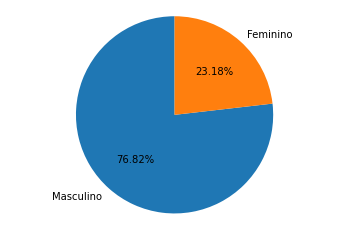

In [48]:
freq_fig, freq_ax = plt.subplots()
freq_ax.pie([qnt_masculino, qnt_feminino], labels = ("Masculino", "Feminino"), autopct = '%1.2f%%', startangle = 90)
freq_ax.axis('equal')
freq_fig.savefig("./figures/svg/freq_sexo_pie.svg")
freq_fig.savefig("./figures/png/freq_sexo_pie.png")

No gráfico de pizza acima podemos visualizar de forma geral tal disbribuição.

## Análise da massa salarial de homens e mulheres:

In [53]:
# Pegando a massa salarial de homens e mulheres nos dados:

massa_salarial_masculino = RAIS_2009_masculino.Remuneração.sum()
massa_salarial_feminino = RAIS_2009_feminino.Remuneração.sum()

print("Massa salarial trabalhadores masculinos: {:.2f}.\n" \
      "Massa salarial trabalhadores femininos: {:.2f}.\n" \
      "A massa salarial dos homens é {:.2f} vezes maior que das mulheres.".format(massa_salarial_masculino, massa_salarial_feminino, massa_salarial_masculino / massa_salarial_feminino))

Massa salarial trabalhadores masculinos: 322887135.48.
Massa salarial trabalhadores femininos: 93207101.74.
A massa salarial dos homens é 3.46 vezes maior que das mulheres.


A massa salarial geralmente acompanha a proporção entre a quantidade de homens e mulheres, porém, temos uma pequena diferença neste caso.

Ao verificarmos a proporção entre homens e mulheres, temos 3.31 vezes homens a mais que mulheres, mas ao olharmos para a massa salarial verificamos que a massa salarial dos homens é 3.46 vezes a das mulheres, 0.15 vezes a mais que a proporção na quantidade.

Isto pode demonstrar de início que possível teremos alguma diferença salarial na média entre os sexos.

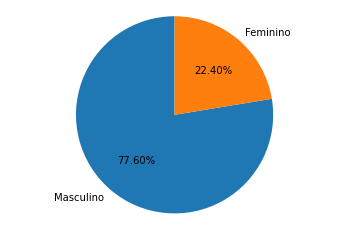

In [54]:
freq_fig, freq_ax = plt.subplots()
freq_ax.pie([massa_salarial_masculino, massa_salarial_feminino], labels = ("Masculino", "Feminino"), autopct = '%1.2f%%', startangle = 90)
freq_ax.axis('equal')
freq_fig.savefig("./figures/svg/massa_sexo_pie.svg")
freq_fig.savefig("./figures/png/massa_sexo_pie.png")

No gráfico de pizza anterior a este, referente as quantidades de cada sexo, temos as porcentagens: masculino com 76.82% e feminino com 23.18%. Ao comparar com o gráfico da massa salarial (acima), temos os respectivos valores para homens e mulheres: 77.60% e 22.40%, demonstrando visualmente uma possível diferença salarial entre os sexos, em desfavorecimento as mulheres.

Para concluirmos melhor esta possibilidade, a seguir é realizado uma análise das médias salariais em cada sexo e comparadas.

## Análise das médias salariais e diferenças:

<AxesSubplot:xlabel='Remuneração', ylabel='Sexo'>

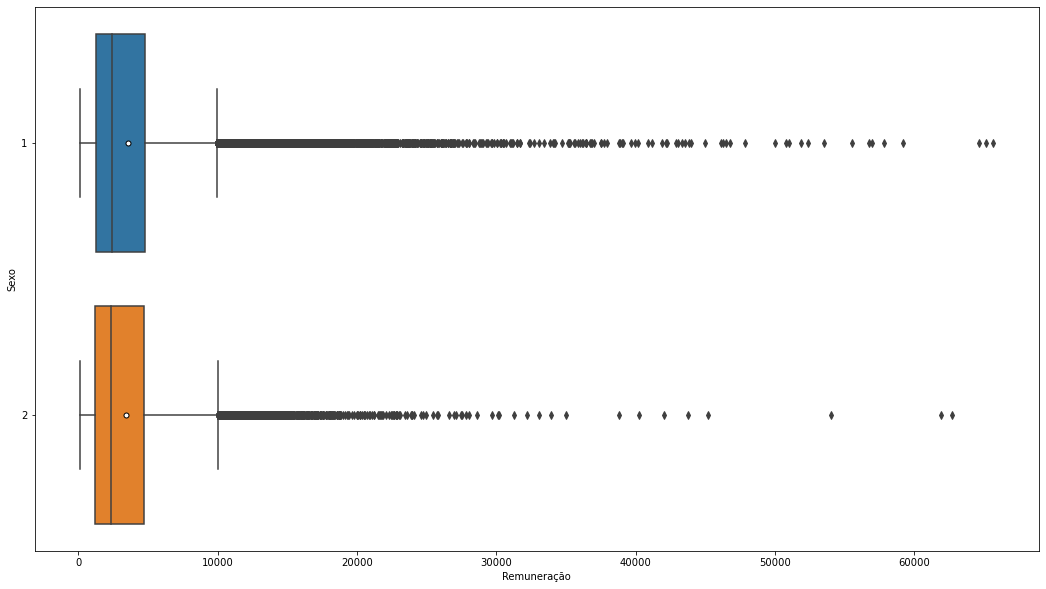

In [7]:
box = sns.boxplot(x = 'Remuneração', y = 'Sexo', data = RAIS_2009, orient = 'h', showmeans=True, meanprops={"marker":"o",
                       "markerfacecolor":"white", 
                       "markeredgecolor":"black",
                      "markersize":"5"})
box.figure.set_size_inches(18, 10)
box

In [60]:
# Capturando as médias e medianas

media_masculino = RAIS_2009_masculino.Remuneração.mean()
mediana_masculino = RAIS_2009_masculino.Remuneração.median()

media_feminino = RAIS_2009_feminino.Remuneração.mean()
mediana_feminino = RAIS_2009_feminino.Remuneração.median()

# Exibindo os dados: 

print("Masculino:")
print("Média das remunerações: R$ {:.2f}\n" \
      "Mediana das remunerações: R$ {:.2f}".format(media_masculino, mediana_masculino))

print()

print("Feminino:")
print("Média das remunerações: R$ {:.2f}\n" \
      "Mediana das remunerações: R$ {:.2f}".format(media_feminino, mediana_feminino))

print()

# Tirando os percentuais de diferença:

dif_salarial_media = media_masculino - media_feminino
taxa_dif_media = ((media_feminino - media_masculino) / media_masculino) * 100

print("Diferença salarial média: R$ {:.2f}\n" \
      "Variação percentual média: {:.2f} %".format(dif_salarial_media, taxa_dif_media))

Masculino:
Média das remunerações: R$ 3610.14
Mediana das remunerações: R$ 2449.25

Feminino:
Média das remunerações: R$ 3453.39
Mediana das remunerações: R$ 2357.21

Diferença salarial média: R$ 156.74
Variação percentual média: -4.34 %


Ao verificarmos as médias salariais para cada sexo, temos que as **mulheres** recebem **4.34% a menos** que os **homens**, para o ano de 2009 em um recorte dos dados para ocupações consideradas de TI e para os setores de TI somente. Assim, **podemos concluir** que **existe diferença salarial** geral entre homens e mulheres, em **desfavorecimento para as mulheres**.

Porém, para afirmar que estatisticamente estes dados são comparáveis, é necessário realizar um teste de hipótese entre os dois grupos, comparando se as médias realmente menores uma que a outra.

## Teste de hipótese para as médias:

Para testar se a média das mulheres é estatisticamente menor que a média dos homens, será utilizado o teste não paramétrico de Mann-Whitney, visto que os grupos não são pareados, ou seja, são grupos que não dependem um do outro.

In [71]:
stat, p_valor = mannwhitneyu(RAIS_2009_feminino.Remuneração, RAIS_2009_masculino.Remuneração, alternative = 'less')

print("Estatística Mann-Whitney = {:.2f}, p-valor = {:.15f}".format(stat, p_valor))

if p_valor <= nivel_confianca:
    print('A média salarial das mulheres é menor que a média dos homens (rejeitar H0)')
else:
    print('As médias não são diferentes (falha ao rejeitar H0)')

Estatística Mann-Whitney = 1170131704.00, p-valor = 0.000000000000013
A média salarial das mulheres é menor que a média dos homens (rejeitar H0)


Ao rejeitar a hipótese nula do teste Mann-Whitney, da qual aponta que não há diferenças entra as médias, podemos inferir estatisticamente que a média salarial feminina é menor que a média salarial masculina, demonstrando de que as diferenças são estatisticamente possíveis e sustentando a possível realidade entre esta diferença salarial.